# Regression Deep Learning Model for NCAA Women's Volleyball Win-Loss Percentages Using TensorFlow
### David Lowe
### May 8, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The NCAA Women's Volleyball dataset is a classic regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: NCAA maintains and publishes numerous datasets on its sporting events and statistics. The goal of this exercise is to experiment with the non-neural-network machine learning (ML) algorithms and observe whether we can use those classic ML techniques to model the sport of volleyball.

ANALYSIS: The baseline model with a single layer of 8 nodes processed the test dataset and produced an RMSE of 0.0797 after 200 epochs. The alternate model with a single layer of 12 nodes processed the test dataset and yielded an RMSE of 0.0667 after 200 epochs. Other model architectures with more layers did not significantly improve the baseline model's result.

CONCLUSION: For this iteration, the baseline model with a single layer of 12 nodes appeared to have yielded the best result. For this dataset, we should consider experimenting with more and different MLP models.

Dataset Used: NCAA Women's Volleyball Archived Statistics

Dataset ML Model: Regression with numerical attributes

Dataset Reference: http://web1.ncaa.org/stats/StatsSrv/rankings?doWhat=archive&sportCode=WVB

Any deep-learning modeling project generally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the random seed number for reproducible results
seedNum = 888

In [2]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.GlorotNormal(seed=seedNum)
default_epoch = 200
default_batch = 16

Num GPUs Available:  0


In [4]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [6]:
if notifyStatus: email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if notifyStatus: email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
# Aces Per Set
df01 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_01.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df01.drop(columns=['Rank', 'W-L'], inplace=True)
df01.dropna(axis=0, how='all', inplace=True)
df01.rename(columns={"S": "Sets", "Per Set": "Aces_Per_Set"}, inplace=True)

# Assists Per Set
df02 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_02.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df02.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df02.dropna(axis=0, how='all', inplace=True)
df02.rename(columns={"Per Set": "Assists_Per_Set"}, inplace=True)

# Blocks Per Set
df03 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_03.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df03.dropna(axis=0, how='all', inplace=True)
df03['Total_Blocks'] = df03['Block Solos'] + (df03['Block Assists'] / 2)
df03.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df03.rename(columns={"Block Solos": "Block_Solos", "Block Assists": "Block_Assists", "Per Set": "Blocks_Per_Set"}, inplace=True)

# Digs Per Set
df04 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_04.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df04.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df04.dropna(axis=0, how='all', inplace=True)
df04.rename(columns={"Per Set": "Digs_Per_Set"}, inplace=True)

# Attacks, Errors, and Hitting Percentage
df05 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_05.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df05.dropna(axis=0, how='all', inplace=True)
df05['Attack_Per_Set'] = df05['Total Attacks'] / df05['S']
df05.drop(columns=['Rank', 'S', 'W-L', 'Kills'], inplace=True)
df05.rename(columns={"Errors": "Team_Errors", "Total Attacks": "Team_Attacks", "Pct.": "Team_Hit_Pct"}, inplace=True)

# Kills Per Set
df06 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_06.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df06.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df06.dropna(axis=0, how='all', inplace=True)
df06.rename(columns={"Kills": "Team_Kills", "Per Set": "Kills_Per_Set"}, inplace=True)

# Match W-L Percentage
df07 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_07.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df07.drop(columns=['Rank'], inplace=True)
df07.dropna(axis=0, how='all', inplace=True)
df07.rename(columns={"W": "Wins", "L": "Losses", "Pct.": "Win_Pct"}, inplace=True)

# Opponent Hitting Percentage
df08 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_08.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df08.drop(columns=['Rank', 'S'], inplace=True)
df08.dropna(axis=0, how='all', inplace=True)
df08.rename(columns={"Opp Kills": "Opp_Kills", "Opp Errors": "Opp_Errors", "Opp Attacks": "Opp_Attacks", "Opp Pct": "Opp_Hit_Pct"}, inplace=True)

# Merge sub-tables into the main table
Xy_original = pd.merge(df07, df01, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df02, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df03, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df04, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df05, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df06, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df08, on=['Name', 'Name'])

# Take a peek at the dataframe after the import
Xy_original.head(10)

,Name,Wins,Losses,Win_Pct,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,SFA,31.0,2.0,0.939,114.0,148.0,1.30,1343.0,11.78,72.0,...,406.0,4168.0,0.258,36.561404,1481.0,12.99,1457.0,760.0,4628.0,0.151
1,Western Ky.,31.0,2.0,0.939,114.0,211.0,1.85,1440.0,12.63,75.0,...,448.0,3626.0,0.304,31.807018,1550.0,13.60,1220.0,656.0,3668.0,0.154
2,Pittsburgh,30.0,2.0,0.938,111.0,156.0,1.41,1517.0,13.67,33.0,...,562.0,3851.0,0.277,34.693694,1627.0,14.66,1188.0,641.0,3692.0,0.148
3,Baylor,29.0,2.0,0.935,104.0,116.0,1.12,1421.0,13.66,42.0,...,500.0,3498.0,0.291,33.634615,1518.0,14.60,1208.0,622.0,3561.0,0.165
4,Colorado St.,29.0,2.0,0.935,110.0,182.0,1.65,1419.0,12.90,75.0,...,512.0,3490.0,0.285,31.727273,1508.0,13.71,1054.0,667.0,3482.0,0.111
5,South Dakota,31.0,3.0,0.912,123.0,178.0,1.45,1652.0,13.43,46.0,...,600.0,4392.0,0.265,35.707317,1762.0,14.33,1383.0,693.0,4422.0,0.156
6,Towson,29.0,3.0,0.906,112.0,161.0,1.44,1491.0,13.31,26.0,...,546.0,3929.0,0.269,35.080357,1604.0,14.32,1240.0,651.0,3951.0,0.149
7,Stanford,30.0,4.0,0.882,120.0,162.0,1.35,1674.0,13.95,30.0,...,502.0,4236.0,0.302,35.300000,1780.0,14.83,1436.0,678.0,4304.0,0.176
8,New Mexico St.,27.0,4.0,0.871,108.0,153.0,1.42,1354.0,12.54,65.0,...,529.0,3590.0,0.262,33.240741,1470.0,13.61,1113.0,682.0,3558.0,0.121
9,Hawaii,26.0,4.0,0.867,114.0,156.0,1.37,1428.0,12.53,66.0,...,548.0,4036.0,0.249,35.403509,1553.0,13.62,1338.0,662.0,4014.0,0.168


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             335 non-null    object 
 1   Wins             335 non-null    float64
 2   Losses           335 non-null    float64
 3   Win_Pct          335 non-null    float64
 4   Sets             335 non-null    float64
 5   Aces             335 non-null    float64
 6   Aces_Per_Set     335 non-null    float64
 7   Assists          335 non-null    float64
 8   Assists_Per_Set  335 non-null    float64
 9   Block_Solos      335 non-null    float64
 10  Block_Assists    335 non-null    float64
 11  Blocks_Per_Set   335 non-null    float64
 12  Total_Blocks     335 non-null    float64
 13  Digs             335 non-null    float64
 14  Digs_Per_Set     335 non-null    float64
 15  Team_Errors      335 non-null    float64
 16  Team_Attacks     335 non-null    float64
 17  Team_Hit_Pct    

In [10]:
Xy_original.describe()

,Wins,Losses,Win_Pct,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.00000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,14.997015,14.970149,0.494487,111.755224,148.608955,1.326627,1290.21194,11.509761,50.179104,353.791045,...,588.871642,3916.134328,0.204433,34.998666,1393.137313,12.428866,1392.659701,588.805970,3916.059701,0.206543
std,6.594090,5.736662,0.200688,10.773655,30.983083,0.226591,198.63768,1.133987,17.439824,92.662955,...,79.863234,468.155212,0.040488,1.862970,209.869304,1.167305,147.878482,82.159411,467.170918,0.028195
min,0.000000,2.000000,0.000000,74.000000,77.000000,0.730000,584.00000,7.120000,16.000000,120.000000,...,334.000000,2257.000000,0.049000,27.524390,635.000000,7.740000,931.000000,260.000000,2188.000000,0.111000
25%,10.000000,11.000000,0.367000,106.000000,126.000000,1.150000,1164.00000,10.900000,37.000000,288.000000,...,533.500000,3637.000000,0.181000,33.753412,1261.500000,11.815000,1301.000000,538.000000,3640.500000,0.190000
50%,14.000000,15.000000,0.483000,112.000000,145.000000,1.300000,1308.00000,11.640000,48.000000,344.000000,...,590.000000,3927.000000,0.203000,35.066667,1421.000000,12.520000,1393.000000,584.000000,3925.000000,0.209000
75%,20.000000,19.000000,0.636000,118.000000,170.000000,1.475000,1420.00000,12.225000,61.000000,412.000000,...,638.500000,4212.000000,0.229000,36.090914,1529.000000,13.190000,1477.500000,644.000000,4180.000000,0.223000
max,31.000000,31.000000,0.939000,142.000000,263.000000,2.070000,1775.00000,14.200000,108.000000,630.000000,...,794.000000,5231.000000,0.325000,39.873950,1909.000000,15.110000,1859.000000,850.000000,5162.000000,0.321000


In [11]:
Xy_original.isnull().sum()

Name               0
Wins               0
Losses             0
Win_Pct            0
Sets               0
Aces               0
Aces_Per_Set       0
Assists            0
Assists_Per_Set    0
Block_Solos        0
Block_Assists      0
Blocks_Per_Set     0
Total_Blocks       0
Digs               0
Digs_Per_Set       0
Team_Errors        0
Team_Attacks       0
Team_Hit_Pct       0
Attack_Per_Set     0
Team_Kills         0
Kills_Per_Set      0
Opp_Kills          0
Opp_Errors         0
Opp_Attacks        0
Opp_Hit_Pct        0
dtype: int64

In [12]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'Win_Pct': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['Name','Wins','Losses'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,targetVar,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,0.939,114.0,148.0,1.30,1343.0,11.78,72.0,497.0,2.81,320.5,...,406.0,4168.0,0.258,36.561404,1481.0,12.99,1457.0,760.0,4628.0,0.151
1,0.939,114.0,211.0,1.85,1440.0,12.63,75.0,346.0,2.18,248.0,...,448.0,3626.0,0.304,31.807018,1550.0,13.60,1220.0,656.0,3668.0,0.154
2,0.938,111.0,156.0,1.41,1517.0,13.67,33.0,484.0,2.48,275.0,...,562.0,3851.0,0.277,34.693694,1627.0,14.66,1188.0,641.0,3692.0,0.148
3,0.935,104.0,116.0,1.12,1421.0,13.66,42.0,444.0,2.54,264.0,...,500.0,3498.0,0.291,33.634615,1518.0,14.60,1208.0,622.0,3561.0,0.165
4,0.935,110.0,182.0,1.65,1419.0,12.90,75.0,497.0,2.94,323.5,...,512.0,3490.0,0.285,31.727273,1508.0,13.71,1054.0,667.0,3482.0,0.111
5,0.912,123.0,178.0,1.45,1652.0,13.43,46.0,514.0,2.46,303.0,...,600.0,4392.0,0.265,35.707317,1762.0,14.33,1383.0,693.0,4422.0,0.156
6,0.906,112.0,161.0,1.44,1491.0,13.31,26.0,527.0,2.58,289.5,...,546.0,3929.0,0.269,35.080357,1604.0,14.32,1240.0,651.0,3951.0,0.149
7,0.882,120.0,162.0,1.35,1674.0,13.95,30.0,630.0,2.88,345.0,...,502.0,4236.0,0.302,35.300000,1780.0,14.83,1436.0,678.0,4304.0,0.176
8,0.871,108.0,153.0,1.42,1354.0,12.54,65.0,495.0,2.89,312.5,...,529.0,3590.0,0.262,33.240741,1470.0,13.61,1113.0,682.0,3558.0,0.121
9,0.867,114.0,156.0,1.37,1428.0,12.53,66.0,471.0,2.64,301.5,...,548.0,4036.0,0.249,35.403509,1553.0,13.62,1338.0,662.0,4014.0,0.168


In [14]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   targetVar        335 non-null    float64
 1   Sets             335 non-null    float64
 2   Aces             335 non-null    float64
 3   Aces_Per_Set     335 non-null    float64
 4   Assists          335 non-null    float64
 5   Assists_Per_Set  335 non-null    float64
 6   Block_Solos      335 non-null    float64
 7   Block_Assists    335 non-null    float64
 8   Blocks_Per_Set   335 non-null    float64
 9   Total_Blocks     335 non-null    float64
 10  Digs             335 non-null    float64
 11  Digs_Per_Set     335 non-null    float64
 12  Team_Errors      335 non-null    float64
 13  Team_Attacks     335 non-null    float64
 14  Team_Hit_Pct     335 non-null    float64
 15  Attack_Per_Set   335 non-null    float64
 16  Team_Kills       335 non-null    float64
 17  Kills_Per_Set   

In [15]:
Xy_original.describe()

,targetVar,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
count,335.000000,335.000000,335.000000,335.000000,335.00000,335.000000,335.000000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.494487,111.755224,148.608955,1.326627,1290.21194,11.509761,50.179104,353.791045,2.028090,227.074627,...,588.871642,3916.134328,0.204433,34.998666,1393.137313,12.428866,1392.659701,588.805970,3916.059701,0.206543
std,0.200688,10.773655,30.983083,0.226591,198.63768,1.133987,17.439824,92.662955,0.377804,49.201807,...,79.863234,468.155212,0.040488,1.862970,209.869304,1.167305,147.878482,82.159411,467.170918,0.028195
min,0.000000,74.000000,77.000000,0.730000,584.00000,7.120000,16.000000,120.000000,0.970000,76.000000,...,334.000000,2257.000000,0.049000,27.524390,635.000000,7.740000,931.000000,260.000000,2188.000000,0.111000
25%,0.367000,106.000000,126.000000,1.150000,1164.00000,10.900000,37.000000,288.000000,1.775000,194.500000,...,533.500000,3637.000000,0.181000,33.753412,1261.500000,11.815000,1301.000000,538.000000,3640.500000,0.190000
50%,0.483000,112.000000,145.000000,1.300000,1308.00000,11.640000,48.000000,344.000000,2.030000,224.000000,...,590.000000,3927.000000,0.203000,35.066667,1421.000000,12.520000,1393.000000,584.000000,3925.000000,0.209000
75%,0.636000,118.000000,170.000000,1.475000,1420.00000,12.225000,61.000000,412.000000,2.245000,255.750000,...,638.500000,4212.000000,0.229000,36.090914,1529.000000,13.190000,1477.500000,644.000000,4180.000000,0.223000
max,0.939000,142.000000,263.000000,2.070000,1775.00000,14.200000,108.000000,630.000000,3.180000,356.500000,...,794.000000,5231.000000,0.325000,39.873950,1909.000000,15.110000,1859.000000,850.000000,5162.000000,0.321000


In [16]:
Xy_original.isnull().sum()

targetVar          0
Sets               0
Aces               0
Aces_Per_Set       0
Assists            0
Assists_Per_Set    0
Block_Solos        0
Block_Assists      0
Blocks_Per_Set     0
Total_Blocks       0
Digs               0
Digs_Per_Set       0
Team_Errors        0
Team_Attacks       0
Team_Hit_Pct       0
Attack_Per_Set     0
Team_Kills         0
Kills_Per_Set      0
Opp_Kills          0
Opp_Errors         0
Opp_Attacks        0
Opp_Hit_Pct        0
dtype: int64

In [17]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [18]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (335, 22) X_original.shape: (335, 21) y_original.shape: (335,)


In [20]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

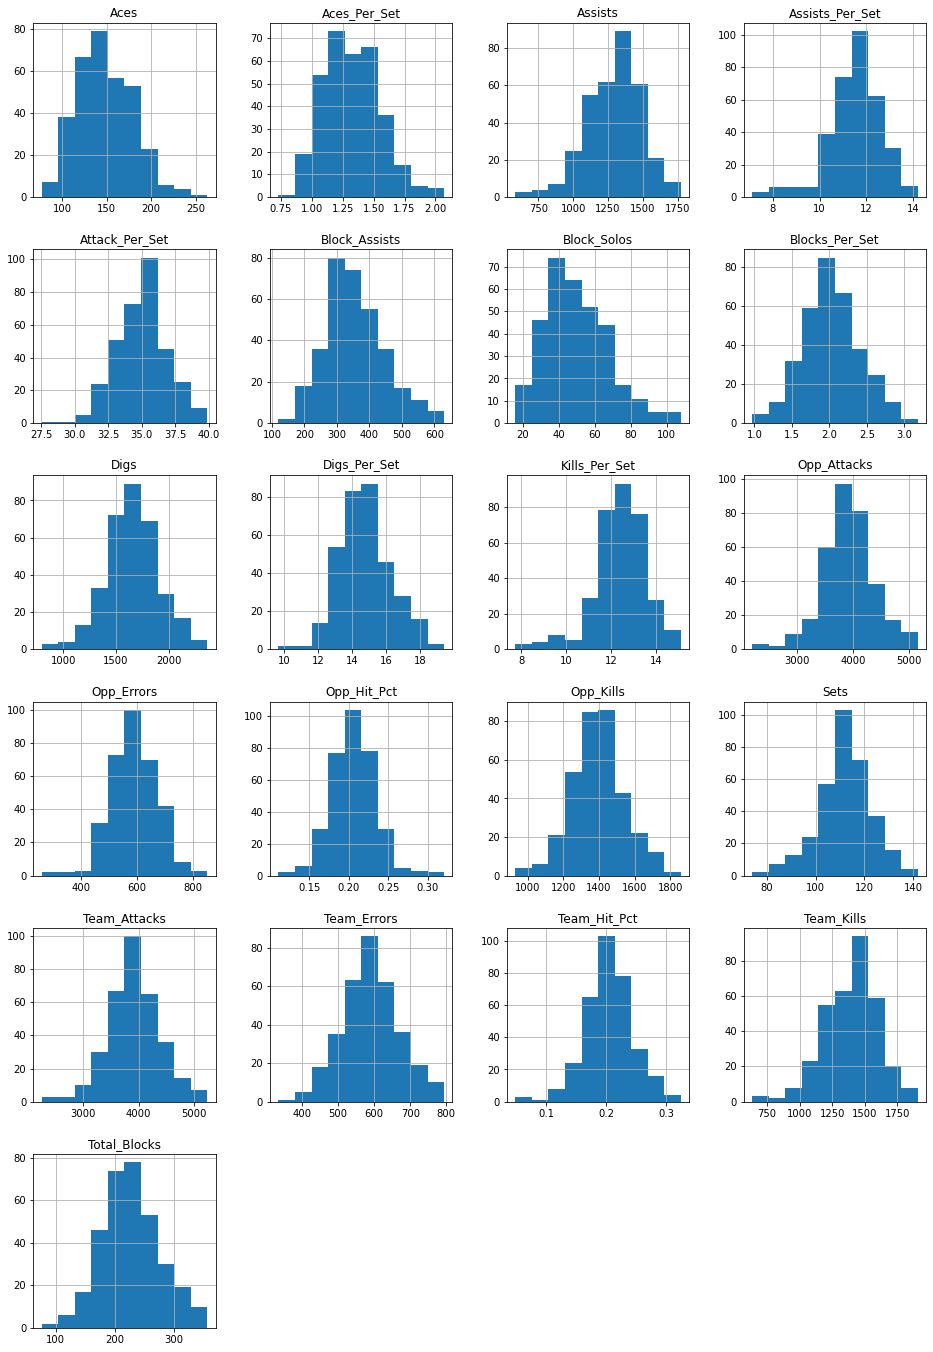

In [21]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [22]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['Sets', 'Aces', 'Aces_Per_Set', 'Assists', 'Assists_Per_Set', 'Block_Solos', 'Block_Assists', 'Blocks_Per_Set', 'Total_Blocks', 'Digs', 'Digs_Per_Set', 'Team_Errors', 'Team_Attacks', 'Team_Hit_Pct', 'Attack_Per_Set', 'Team_Kills', 'Kills_Per_Set', 'Opp_Kills', 'Opp_Errors', 'Opp_Attacks', 'Opp_Hit_Pct']


In [23]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,Digs,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,0.208670,-0.019684,-0.117687,0.266148,0.238665,1.253082,1.547794,2.072715,1.901660,1.428159,...,-2.293235,0.538801,1.325028,0.840097,0.419281,0.481428,0.435740,2.086798,1.526219,-1.972897
1,0.208670,2.016726,2.313228,0.755205,0.989354,1.425360,-0.084205,0.402689,0.425933,-0.130307,...,-1.766550,-0.620667,2.462875,-1.715767,0.748548,1.004781,-1.169325,0.819073,-0.531777,-1.866337
2,-0.070204,0.238908,0.368496,1.143425,1.907845,-0.986524,1.407291,1.197940,0.975514,-0.209618,...,-0.336974,-0.139338,1.795008,-0.163947,1.115992,1.914214,-1.386042,0.636228,-0.480327,-2.079457
3,-0.720909,-1.054051,-0.913259,0.659410,1.899013,-0.469692,0.974973,1.356990,0.751611,-0.610140,...,-1.114463,-0.894489,2.141310,-0.733286,0.595844,1.862736,-1.250594,0.404624,-0.761158,-1.475617
4,-0.163162,1.079331,1.429259,0.649327,1.227809,1.425360,1.547794,2.417324,1.962725,-0.744969,...,-0.963981,-0.911603,1.992895,-1.758636,0.548125,1.099156,-2.293547,0.953159,-0.930514,-3.393697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,-2.580066,-1.409614,-0.338679,-2.829531,-2.499143,-0.125137,-0.992072,0.270148,-0.978552,-2.243952,...,-1.152083,-2.379121,-2.459553,-0.869651,-2.873398,-2.581473,-1.677257,-1.813895,-2.186749,1.294942
321,-0.349078,-0.375247,-0.250282,-2.461478,-3.603097,-0.641969,-1.899939,-2.221637,-2.016650,-1.331873,...,1.493886,-1.191843,-3.597400,-2.094850,-2.329390,-3.473746,-0.688483,-1.472585,-1.342113,1.543582
322,-1.743445,-1.021727,-0.294480,-2.164010,-1.986908,-1.503356,-1.781052,-2.009570,-2.210021,-1.875155,...,-0.989061,-2.060375,-1.717478,-1.744973,-2.310302,-2.281188,-1.548581,-2.594034,-2.081706,2.182942
323,-0.534993,-0.472219,-0.294480,-1.216148,-1.421683,-0.297414,-0.602986,-0.525103,-0.673229,-0.225481,...,0.189712,-0.419578,-1.544327,0.051432,-1.236603,-1.483290,0.070029,-0.424273,-0.280959,0.620062


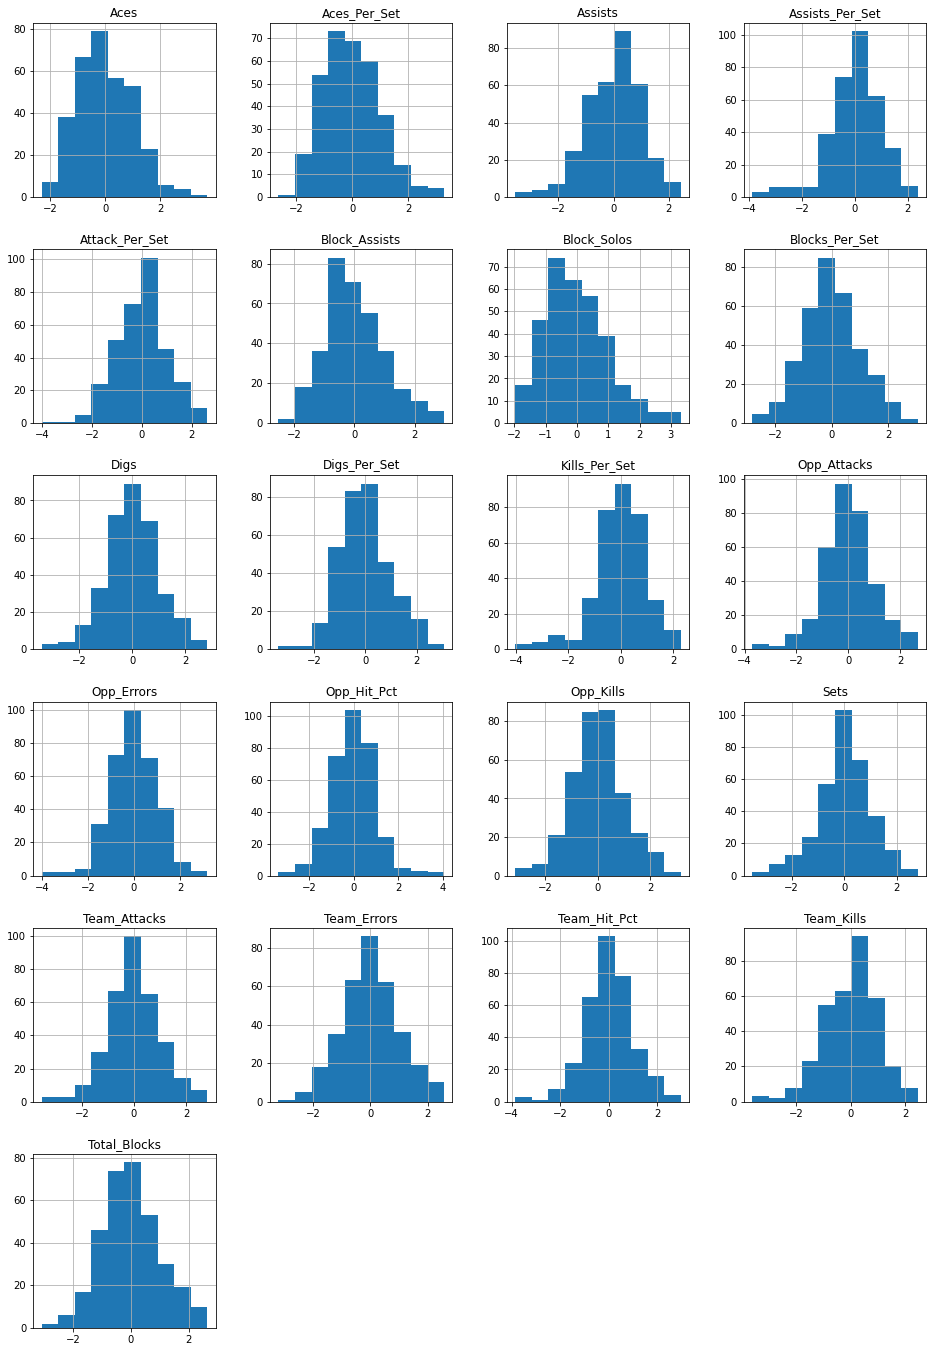

In [24]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [25]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [26]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if splitDataset:
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (251, 21) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (251,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (84, 21) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (84,) y_test.type: <class 'numpy.ndarray'>


In [27]:
if notifyStatus: email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [28]:
if notifyStatus: email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
# Define the baseline model
def create_baseline_model():
    default_model = Sequential()
    default_model.add(Dense(8, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [30]:
if notifyStatus: email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [31]:
if notifyStatus: email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [32]:
# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_baseline_model()
extra_epochs = 0
baseline_hist = baseline_model.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

Train on 251 samples, validate on 84 samples
Epoch 1/200
251/251 [==============================] - 0s 1ms/sample - loss: 0.4652 - val_loss: 0.2085
Epoch 2/200
251/251 [==============================] - 0s 100us/sample - loss: 0.3346 - val_loss: 0.1650
Epoch 3/200
251/251 [==============================] - 0s 108us/sample - loss: 0.2489 - val_loss: 0.1366
Epoch 4/200
251/251 [==============================] - 0s 116us/sample - loss: 0.1922 - val_loss: 0.1197
Epoch 5/200
251/251 [==============================] - 0s 119us/sample - loss: 0.1569 - val_loss: 0.1100
Epoch 6/200
251/251 [==============================] - 0s 131us/sample - loss: 0.1349 - val_loss: 0.1001
Epoch 7/200
251/251 [==============================] - 0s 127us/sample - loss: 0.1156 - val_loss:

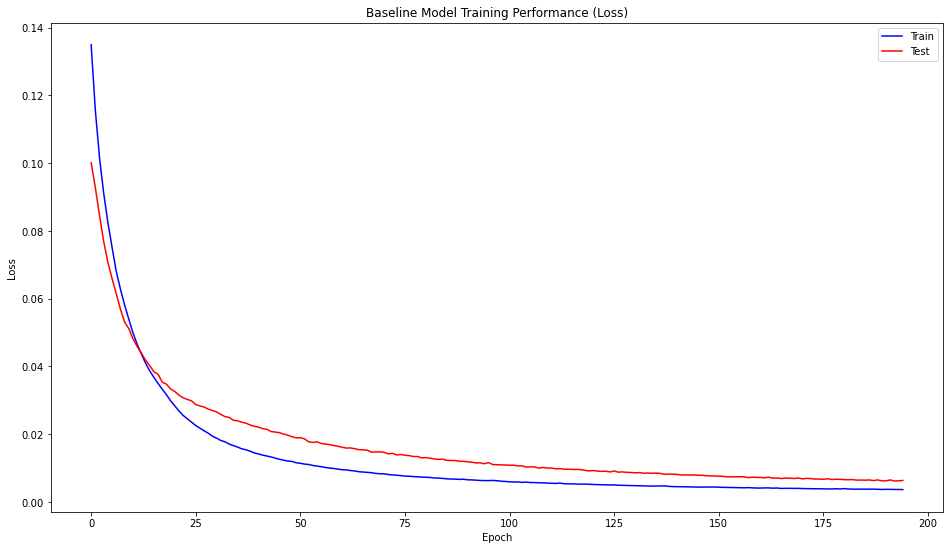

In [33]:
# Summarize baseline model training history
begin_epoch = 5
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [34]:
if notifyStatus: email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Alternate Models

In [35]:
if notifyStatus: email_notify("Phase 4 Explore Alternate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [36]:
# Define MLP model #4a
def create_model_4a():
    default_model = Sequential()
    default_model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
alternate_model_4a = create_model_4a()
extra_epochs = 0
baseline_hist = alternate_model_4a.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

The minimum RMSE for the training dataset: 0.050984074149467415
The RMSE at the last epoch for the training dataset: 0.05149032947668931
The minimum RMSE for the test dataset: 0.06657568148615646
The RMSE at the last epoch for the test dataset: 0.06678096720877742
Total time for model fitting: 0:00:05.026675 



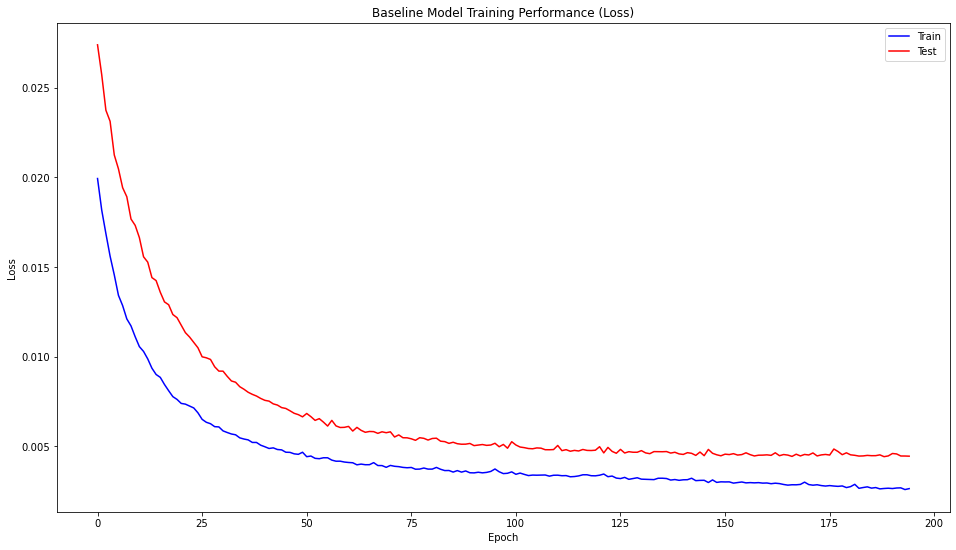

In [37]:
# Summarize model 4a training history
begin_epoch = 5
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [38]:
# Define MLP model #4b
def create_model_4b():
    default_model = Sequential()
    default_model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
alternate_model_4b = create_model_4b()
extra_epochs = 0
baseline_hist = alternate_model_4b.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

The minimum RMSE for the training dataset: 0.04858507222246832
The RMSE at the last epoch for the training dataset: 0.04897171195176642
The minimum RMSE for the test dataset: 0.07209453107384046
The RMSE at the last epoch for the test dataset: 0.07338584582733487
Total time for model fitting: 0:00:04.803123 



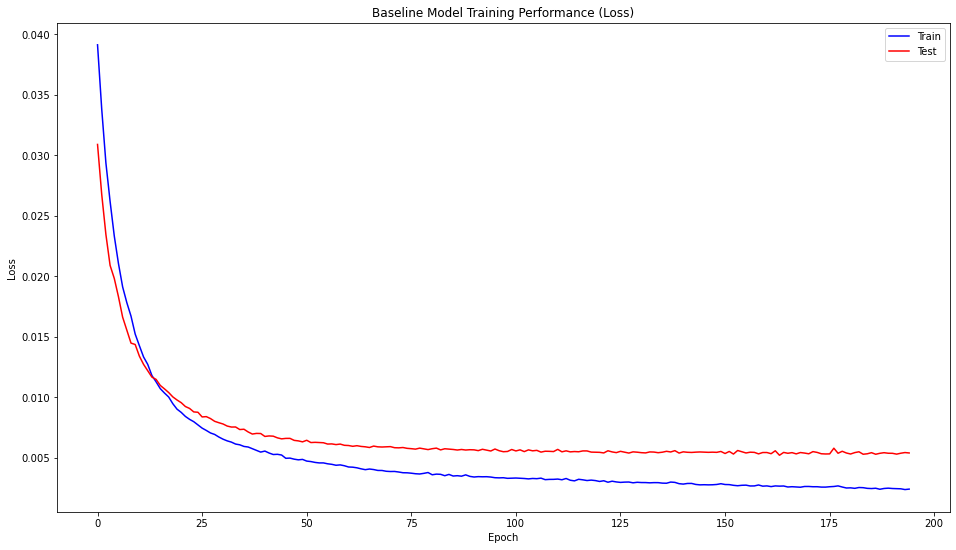

In [39]:
# Summarize model 4b training history
begin_epoch = 5
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [40]:
# Define MLP model #4c
def create_model_4c():
    default_model = Sequential()
    default_model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
alternate_model_4c = create_model_4c()
extra_epochs = 0
baseline_hist = alternate_model_4c.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

The minimum RMSE for the training dataset: 0.0459447395250935
The RMSE at the last epoch for the training dataset: 0.0459447395250935
The minimum RMSE for the test dataset: 0.08223538344417337
The RMSE at the last epoch for the test dataset: 0.08361291587146287
Total time for model fitting: 0:00:05.149202 



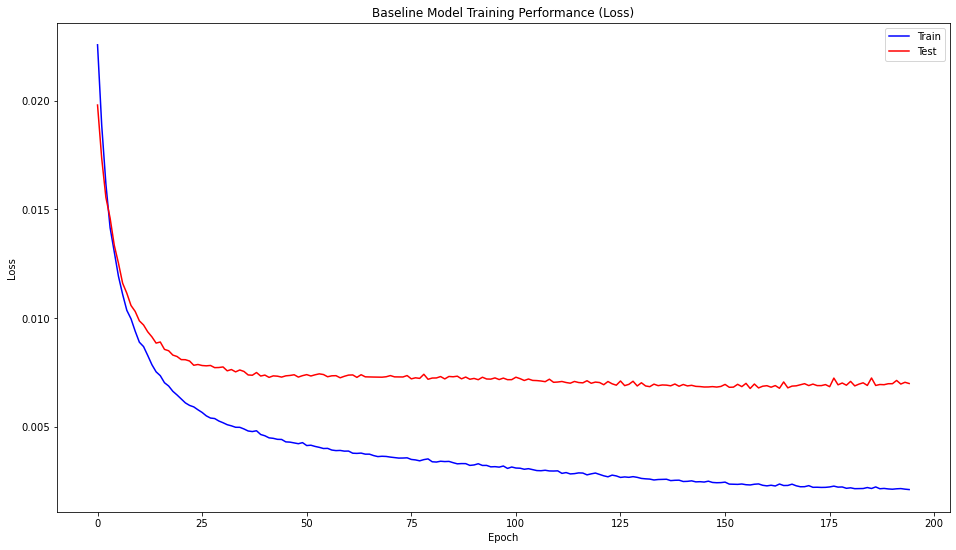

In [41]:
# Summarize model 4c training history
begin_epoch = 5
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [42]:
# Define MLP model #4d
def create_model_4d():
    default_model = Sequential()
    default_model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
alternate_model_4d = create_model_4d()
extra_epochs = 0
baseline_hist = alternate_model_4d.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

The minimum RMSE for the training dataset: 0.05477333917486663
The RMSE at the last epoch for the training dataset: 0.05477333917486663
The minimum RMSE for the test dataset: 0.07268809616900415
The RMSE at the last epoch for the test dataset: 0.07313478015626902
Total time for model fitting: 0:00:05.366942 



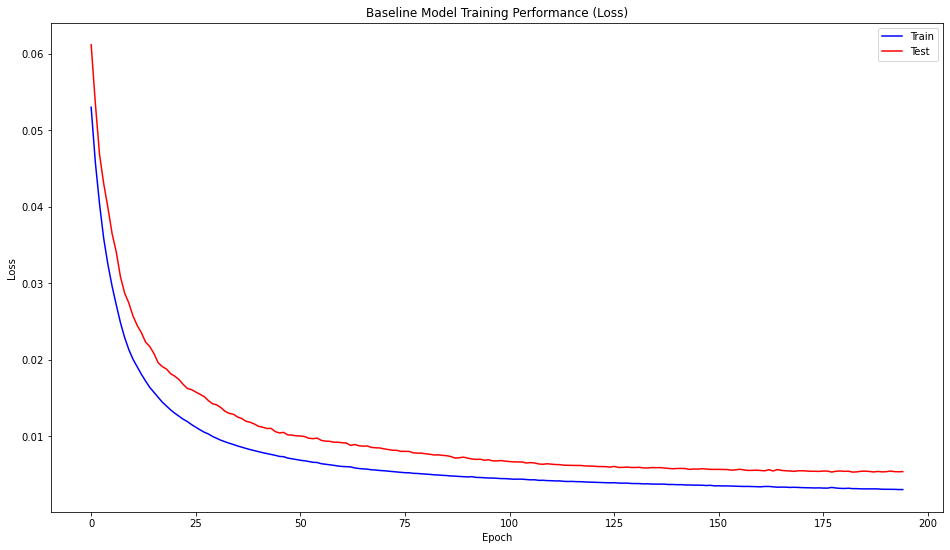

In [43]:
# Summarize model 4d training history
begin_epoch = 5
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [44]:
# Define MLP model #4e
def create_model_4e():
    default_model = Sequential()
    default_model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
alternate_model_4e = create_model_4e()
extra_epochs = 0
baseline_hist = alternate_model_4e.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

The minimum RMSE for the training dataset: 0.08302119444230177
The RMSE at the last epoch for the training dataset: 0.08302119444230177
The minimum RMSE for the test dataset: 0.07167068266865613
The RMSE at the last epoch for the test dataset: 0.07168592572738468
Total time for model fitting: 0:00:07.626937 



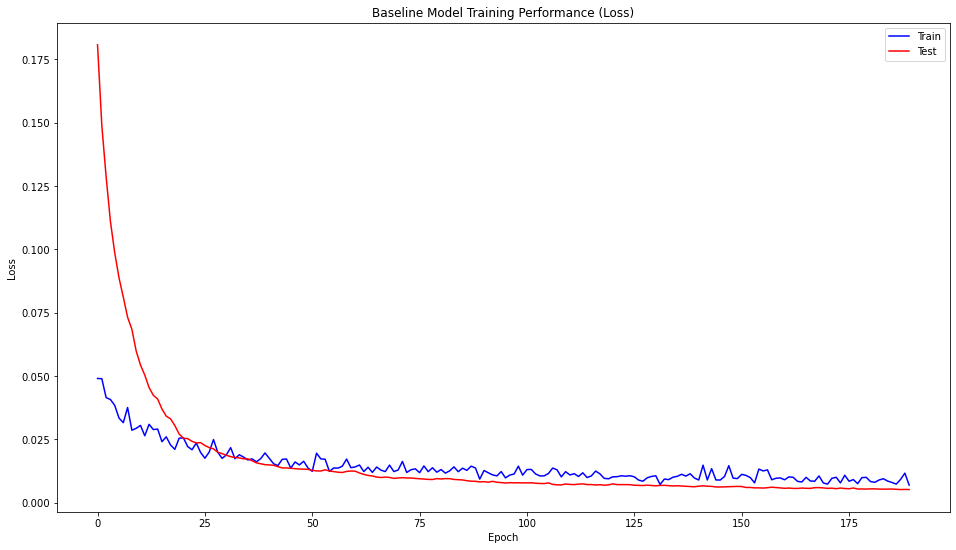

In [45]:
# Summarize model 4e training history
begin_epoch = 10
fig, axs = plt.subplots(1, 1, figsize=(16,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [46]:
if notifyStatus: email_notify("Phase 4 Explore Alternate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [47]:
if notifyStatus: email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
# Display a summary of the final model
final_model = alternate_model_4a
print(final_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_1', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'batch_input_shape': (None, 21), 'dtype': 'float32', 'units': 12, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [50]:
if notifyStatus: email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:43.371590
